In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from matplotlib.font_manager import FontProperties
from itertools import product
from sklearn.metrics import r2_score
import csv
from vme import VME
import itertools

In [2]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# импорт временного ряда

In [3]:
# linux path
# path1 = './'
# path2 = '/'

# windows path
path1 = '.\\'
path2 = '\\'

In [6]:
seasonsTS1 = ("s1")
seasonsTS2 = ("s2")
trendsTS = ("t1", "t2", "t3", "t4", "t5", "t6", "t7")
noisesTS = ("n11", "n11", "n11", "n11", "n11", "n11", "n11")

cases = ("t1_n11_s1_s2", "t2_n11_s1_s2", "t3_n11_s1_s2", "t4_n11_s1_s2", "t5_n11_s1_s2", "t6_n11_s1_s2", "t7_n11_s1_s2")

In [5]:
Trend = list()
for trend_i in trendsTS:
    t = pd.read_csv(f"{path1}Components{path2}{trend_i}.csv", decimal=',')
    trend = pd.DataFrame(t, dtype=float)
    Trend.append(trend['Value'])
Component_of_TS = Trend[::]
Component_name = "Trend"
range_of_imfs = range(5)

Noise = list()
for noise_i in noisesTS:
    n = pd.read_csv(f"{path1}Components{path2}{noise_i}.csv", decimal=',')
    noise = pd.DataFrame(n, dtype=float)
    Noise.append(noise['Value'])
Component_name = "Noise"
range_of_imfs = range(9, 1, -1)
Component_of_TS = Noise[::]

Season = list()
s1 = pd.read_csv(f"{path1}Components{path2}s1.csv", decimal=',')
season1 = pd.DataFrame(s1, dtype=float)
s2 = pd.read_csv(f"{path1}Components{path2}s2.csv", decimal=',')
season2 = pd.DataFrame(s2, dtype=float)
for season_i in range(len(cases)):
    Season.append(season1['Value'] + season2['Value'])
Component_of_TS = Season[::]
Component_name = "Season"
range_of_imfs = range(1,8)


In [7]:
index = list()
TS = list()

data = pd.read_csv(f"{path1}Cases{path2}{cases[0]}.csv", decimal=',')
df = pd.DataFrame(data, dtype=float)
index = df.index

for case_i in cases:
    data = pd.read_csv(f"{path1}Cases{path2}{case_i}.csv", decimal=',')
    df = pd.DataFrame(data, dtype=float)
    TS.append(df.values)

# тестовый анализ

C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


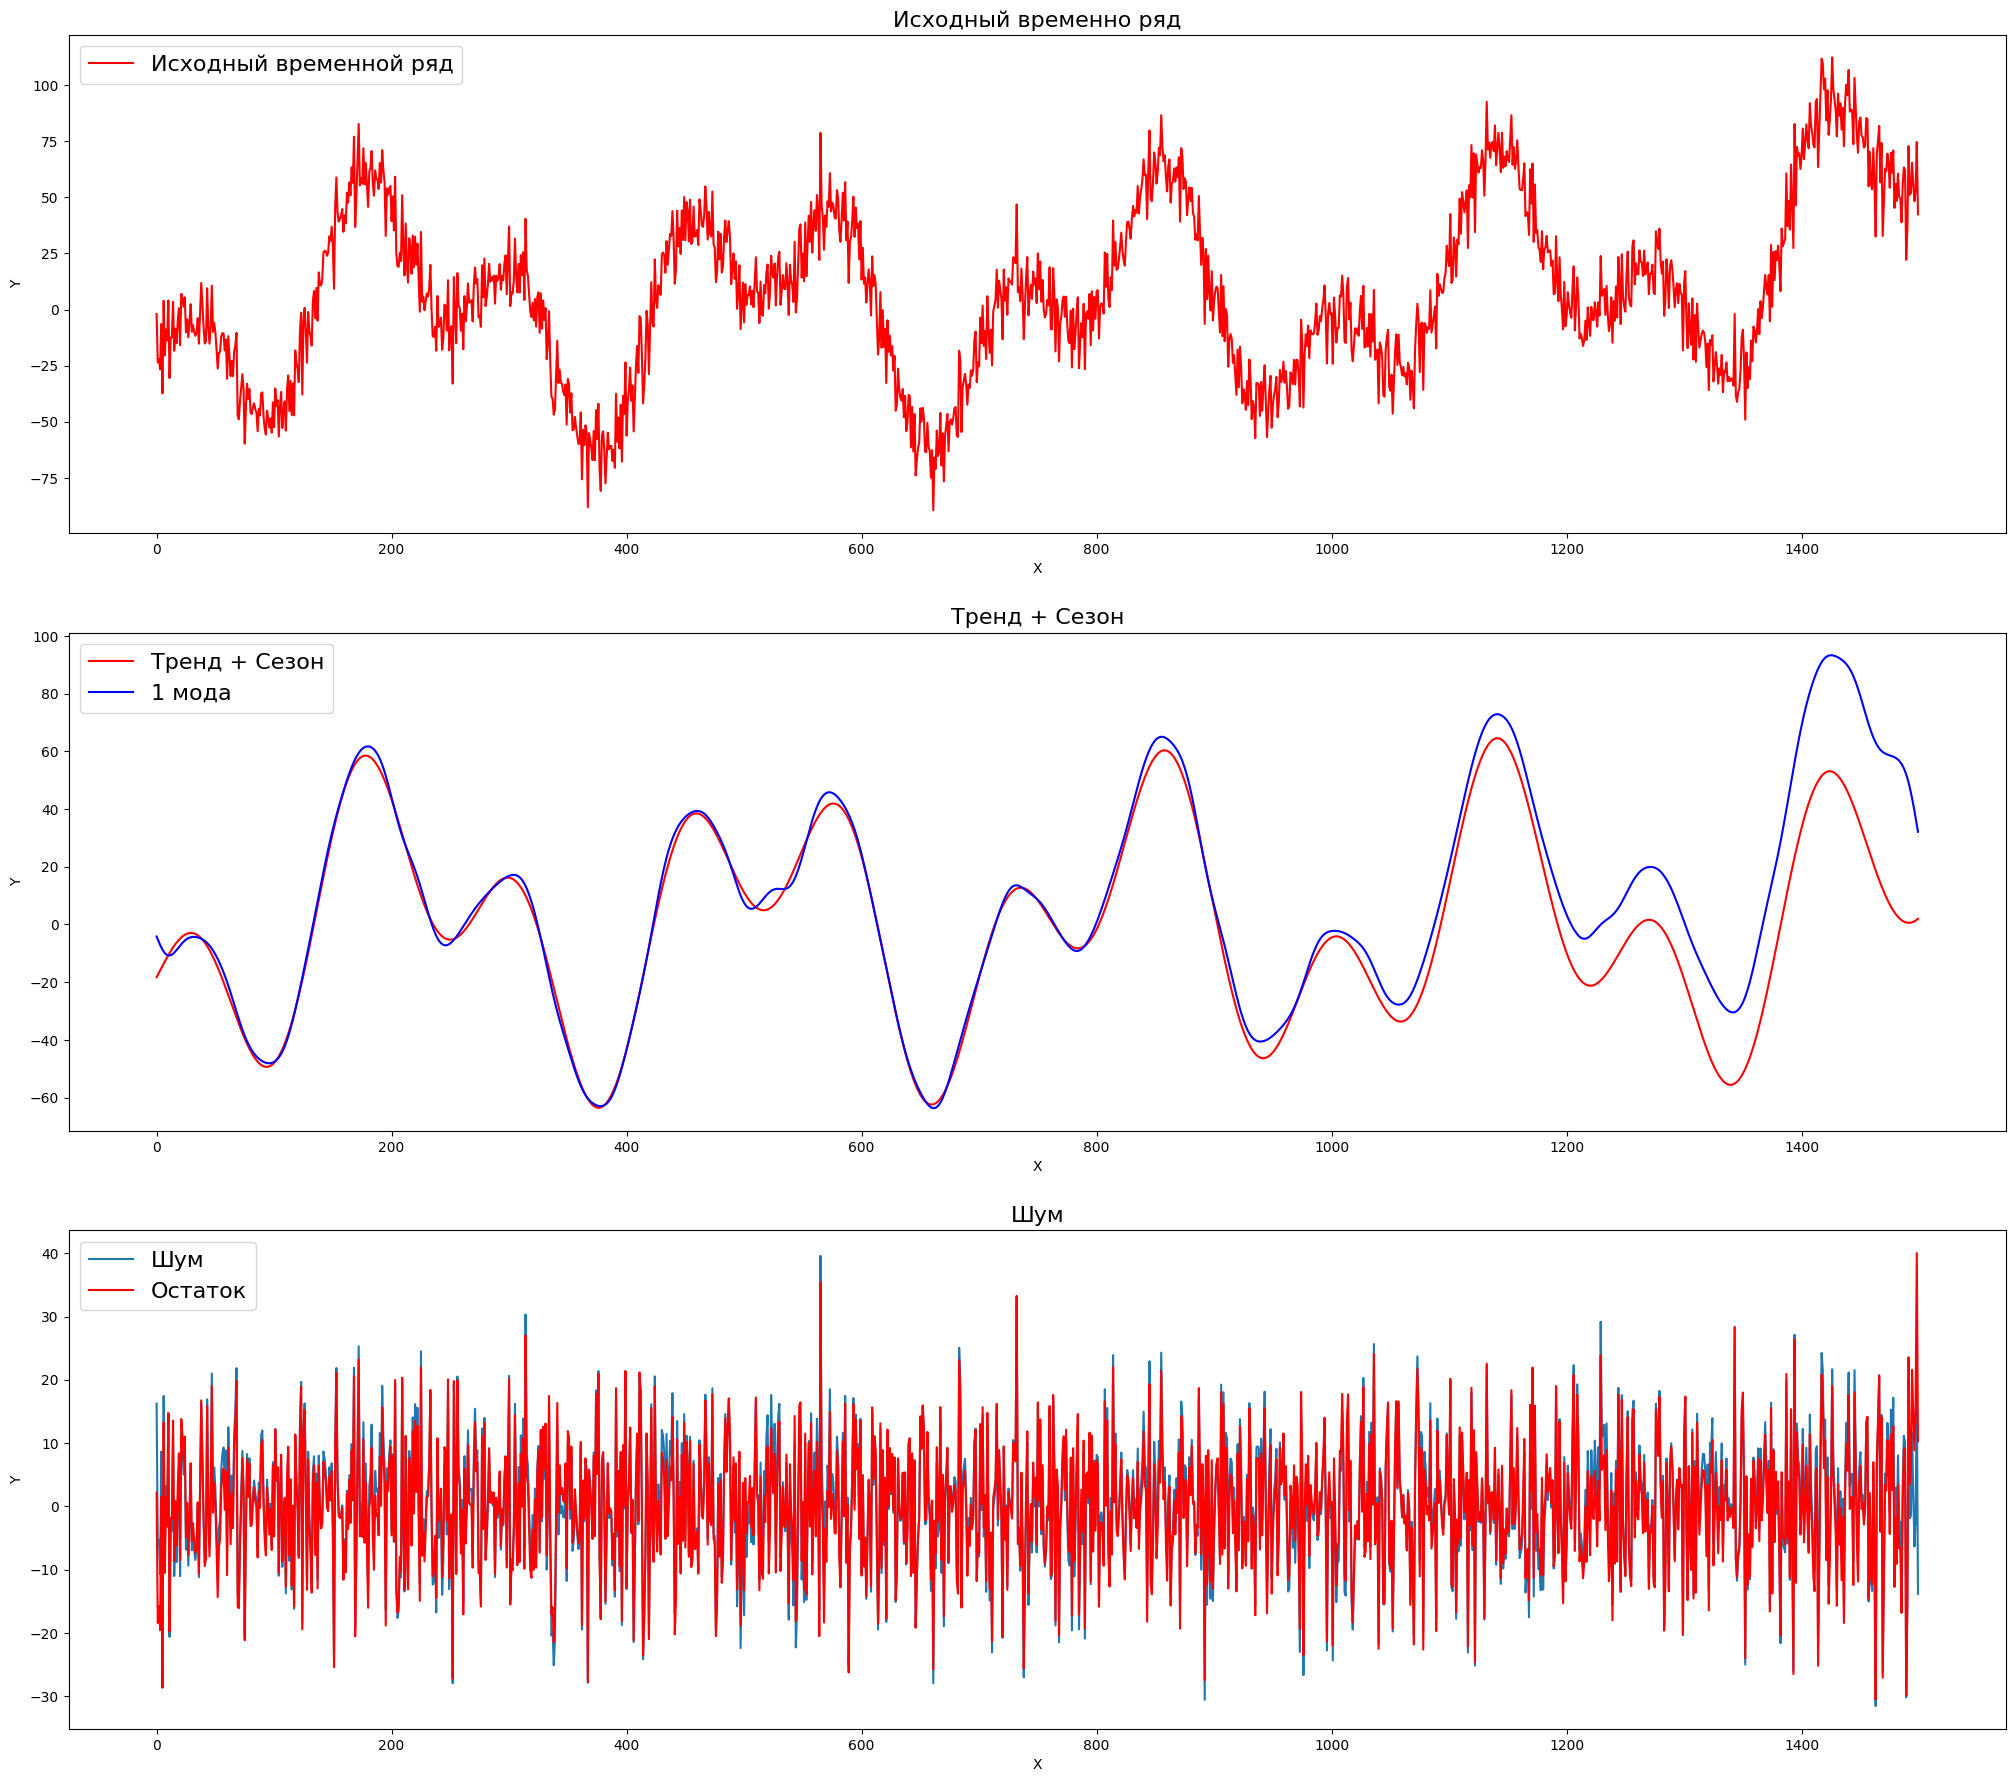

In [14]:
fig, axs = plt.subplots(figsize=(25,22), nrows=3)

axs[0].plot(index, TS[1].T[0], color="#ff0000")
axs[0].set_title('Исходный временно ряд', fontsize=16)
axs[0].set(xlabel = 'X', ylabel='Y')
axs[0].legend(['Исходный временной ряд'], prop=FontProperties(size=16))

alpha = 1000
omega_init = 501

tau = 0
fs = 50000
tol = 1e-6

s1 = pd.read_csv(f"{path1}Components{path2}s1.csv", decimal=',')
season1 = pd.DataFrame(s1, dtype=float)
s2 = pd.read_csv(f"{path1}Components{path2}s2.csv", decimal=',')
season2 = pd.DataFrame(s2, dtype=float)
Component_of_TS = season1['Value'] + season2['Value']
imf, _, _ = VME(TS[1].T[0], Alpha=alpha, omega_int=omega_init, fs=fs, tau=tau, tol=tol)
axs[1].plot(index, Component_of_TS, color="#ff0000")
axs[1].plot(index, imf, color="#0000ff")
axs[1].set_title('Тренд + Сезон', fontsize=16)
axs[1].set(xlabel = 'X', ylabel='Y')
axs[1].legend(['Тренд + Сезон', '1 мода'], prop=FontProperties(size=16))
residual1 = TS[1].T[0] - imf.real



n = pd.read_csv(f"{path1}Components{path2}n11.csv", decimal=',')
noise = pd.DataFrame(n, dtype=float)
Component_of_TS = noise['Value']
axs[2].plot(index, Component_of_TS)
axs[2].plot(index, residual1, color="#ff0000")
axs[2].set_title('Шум', fontsize=16)
axs[2].set(xlabel = 'X', ylabel='Y')
axs[2].legend(['Шум', 'Остаток'], prop=FontProperties(size=16))

# Тренд

In [55]:
# набор параметров
alpha = (0, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000) # moderate bandwidth constraint
omega_init = (1, 501, 1001, 2501, 5001, 7501, 10001, 15001, 20001, 25001, 30001, 35001, 40001, 45001, 50001)
tau = (0, 1, 2, 3, 4, 5) # noise-tolerance (no strict fidelity enforcement)
fs = 20000
tol = 1e-6

featurecount = 5


In [63]:
best_params = np.zeros((len(TS), 10), dtype=dict)
best_metriks = np.zeros((len(TS), 4), dtype=dict)

f = np.zeros((len(TS), 1500), dtype=list)
k_i = np.zeros(len(TS), dtype=int)


In [62]:
#  R2
MetricName = "R2"
calculate_metric = lambda y, y_pred: r2_score(y, y_pred)

default_value = -np.inf
maxmin = lambda criteria: np.max(criteria)
arg_maxmin = lambda criteria: np.argmax(criteria)
find_new_best_params = lambda max_criteria, best_metriks: max_criteria > best_metriks


# #  R2Adj
# MetricName = "R2Adj"
# calculate_metric = lambda y, y_pred, featurecount: r2_score_adjusted(y, y_pred, featurecount)


# #  AIC
# MetricName = "AIC"
# calculate_metric = lambda y, y_pred, k: calculate_aic(y, y_pred, k)

# default_value = np.inf
# maxmin = lambda criteria: np.min(criteria)
# arg_maxmin = lambda criteria: np.argmin(criteria)
# find_new_best_params = lambda max_criteria, best_metriks: max_criteria < best_metriks


# # BIC
# MetricName = "BIC"
# calculate_metric = lambda y, y_pred, k: calculate_bic(y, y_pred, k)

In [64]:
for i in range(len(TS)):
    best_metriks[i][0] = {"Time Series": f"TS{i+1}", "Component": "Trend", f"{MetricName}": default_value}
    best_metriks[i][1] = {"Time Series": f"TS{i+1}", "Component": "Season", f"{MetricName}": default_value}
    best_metriks[i][2] = {"Time Series": f"TS{i+1}", "Component": "Noise", f"{MetricName}": default_value}
    best_metriks[i][3] = {"Time Series": f"TS{i+1}", "Component": "Noise-freg", f"{MetricName}": default_value}
    
    for j in range(10):
        best_params[i][j] = {"Time Series": f"TS{i+1}", "Metric": f"{MetricName}", "Trend/Season/Noise": None, "IMFs" : f"1 - {j+1}",  "alpha": 0, "tau": 0, "W init": 1}

In [ ]:
# для всех лчм
for ts_i in range(len(TS)):
    f[ts_i] = TS[ts_i].reshape((1500,))
    k_i[ts_i] = 0

    best_imfs = 0
    sum_imfs = 0
    isbest_params = True

    while( (k_i[ts_i] < 10) and isbest_params ):
        isbest_params = False

        # для всех значений alpha
        criteria = np.zeros(len(alpha), dtype=float)
        j = 0          # j - индекс значения параметра
        for alpha_i in alpha:
            u, _, _ = VME(f[ts_i], alpha_i, omega_int=1, fs=20000, tau=1, tol=1e-6)

            criteria[j] = calculate_metric(Trend[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][0][f"{MetricName}"]) ):
            best_metriks[ts_i][0][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'1 --- {k_i[ts_i]+1}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Trend"
            best_params[ts_i][k_i[ts_i]]["alpha"] = alpha[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], omega_int=1, fs=20000, tau=1, tol=1e-6)
            best_imfs = u.T.real
            isbest_params = True
        

        # для всех значений omega init
        criteria = np.zeros(len(omega_init), dtype=float)
        j = 0
        for omega_init_i in omega_init:
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], omega_init_i, fs=20000, tau=1, tol=1e-6)

            criteria[j] = calculate_metric(Trend[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][0][f"{MetricName}"]) ):
            best_metriks[ts_i][0][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'1 --- {k_i[ts_i]+1}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Trend"
            best_params[ts_i][k_i[ts_i]]["W init"] = omega_init[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], fs=20000, tau=1, tol=1e-6)
            best_imfs = u.T.real


        # для всех значений tau
        criteria = np.zeros(len(tau), dtype=float)
        j = 0
        for tau_i in tau:
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], fs=20000, tau=tau_i, tol=1e-6)

            criteria[j] = calculate_metric(Trend[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][0][f"{MetricName}"]) ):
            best_metriks[ts_i][0][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'1 --- {k_i[ts_i]+1}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Trend"
            best_params[ts_i][k_i[ts_i]]["tau"] = tau[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], \
                          fs=20000, tau=best_params[ts_i][k_i[ts_i]]["tau"], tol=1e-6)
            
            best_imfs = u.T.real
            isbest_params = True
        


        k_i[ts_i]+=1
        sum_imfs += best_imfs
        if(isbest_params):
            f[ts_i] = f[ts_i] - best_imfs

In [66]:
for ts_i in range(len(TS)):
    best_metriks[ts_i][0][f"{MetricName}"] = format(best_metriks[ts_i][0][f"{MetricName}"], ".5f")

# Сезон

In [67]:
season_k = np.zeros(len(TS), dtype=int)
# для всех лчм
for ts_i in range(len(TS)):
    season_k[ts_i] = k_i[ts_i]
    
    best_imfs = 0
    sum_imfs = 0
    isbest_params = True

    while( (k_i[ts_i] < 10) and isbest_params ):
        isbest_params = False

        # для всех значений alpha
        criteria = np.zeros(len(alpha), dtype=float)
        j = 0          # j - индекс значения параметра
        for alpha_i in alpha:
            u, _, _ = VME(f[ts_i], alpha_i, omega_int=1, fs=20000, tau=1, tol=1e-6)

            criteria[j] = calculate_metric(Season[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][1][f"{MetricName}"]) ):
            best_metriks[ts_i][1][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'{season_k[ts_i]} --- {k_i[ts_i]}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Season"
            best_params[ts_i][k_i[ts_i]]["alpha"] = alpha[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], omega_int=1, fs=20000, tau=1, tol=1e-6)
            best_imfs = u.T.real
            isbest_params = True
        

        # для всех значений omega init
        criteria = np.zeros(len(omega_init), dtype=float)
        j = 0
        for omega_init_i in omega_init:
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], omega_init_i, fs=20000, tau=1, tol=1e-6)

            criteria[j] = calculate_metric(Season[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][1][f"{MetricName}"]) ):
            best_metriks[ts_i][1][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'{season_k[ts_i]} --- {k_i[ts_i]}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Season"
            best_params[ts_i][k_i[ts_i]]["W init"] = omega_init[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], fs=20000, tau=1, tol=1e-6)
            best_imfs = u.T.real


        # для всех значений tau
        criteria = np.zeros(len(tau), dtype=float)
        j = 0
        for tau_i in tau:
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], fs=20000, tau=tau_i, tol=1e-6)

            criteria[j] = calculate_metric(Season[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][1][f"{MetricName}"]) ):
            best_metriks[ts_i][1][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'{season_k[ts_i]} --- {k_i[ts_i]}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Season"
            best_params[ts_i][k_i[ts_i]]["tau"] = tau[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], \
                          fs=20000, tau=best_params[ts_i][k_i[ts_i]]["tau"], tol=1e-6)
            
            best_imfs = u.T.real
            isbest_params = True
        


        k_i[ts_i]+=1
        sum_imfs += best_imfs
        if(isbest_params):
            f[ts_i] = f[ts_i] - best_imfs

In [68]:
for ts_i in range(len(TS)):
    best_metriks[ts_i][1][f"{MetricName}"] = format(best_metriks[ts_i][1][f"{MetricName}"], ".5f")

In [69]:
one_dimensional_best_params = list(itertools.chain(*best_params))

best_params_output = [v for v in one_dimensional_best_params if not (v['Trend/Season/Noise'] is None)]
best_params_output

[{'Time Series': 'TS1',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '1 --- 1',
  'alpha': 50000,
  'tau': 0,
  'W init': 30001},
 {'Time Series': 'TS1',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Season',
  'IMFs': '2 --- 2',
  'alpha': 50000,
  'tau': 0,
  'W init': 2501},
 {'Time Series': 'TS2',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '1 --- 1',
  'alpha': 45000,
  'tau': 0,
  'W init': 1},
 {'Time Series': 'TS2',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Season',
  'IMFs': '2 --- 2',
  'alpha': 40000,
  'tau': 0,
  'W init': 1},
 {'Time Series': 'TS3',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '1 --- 1',
  'alpha': 50000,
  'tau': 0,
  'W init': 5001},
 {'Time Series': 'TS3',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Season',
  'IMFs': '2 --- 2',
  'alpha': 45000,
  'tau': 0,
  'W init': 2501},
 {'Time Series': 'TS4',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '1 --- 1',
  'alpha': 30000,
  'tau': 2,
  'W i

In [70]:
np.shape(one_dimensional_best_params)

(70,)

In [71]:
np.shape(best_params_output)

(21,)

In [72]:
filename=f"./Output-VME/Parameters-{MetricName}-VME.csv"

fields = best_params[0][0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows(best_params_output)  # Write data rows

# Шум

In [73]:
for ts_i in range(len(TS)):
    criteria = calculate_metric(Noise[ts_i], f[ts_i])
    if (find_new_best_params(criteria, best_metriks[ts_i][2][f"{MetricName}"])):
        best_metriks[ts_i][2][f"{MetricName}"] = criteria

# ШУМ freguency

In [74]:
for ts_i in range(len(TS)):
    original_noise = np.abs(np.fft.rfft(Noise[ts_i]))
    imf_freg = np.abs(np.fft.rfft(f[ts_i].astype(float)))

    criteria = calculate_metric(original_noise, imf_freg)
    if (find_new_best_params(criteria, best_metriks[ts_i][3][f"{MetricName}"])):
        best_metriks[ts_i][3][f"{MetricName}"] = criteria

# Вывод

In [75]:
filename=f"./Output-VME/Best_Metriks-{MetricName}-VME.csv"

fields = best_metriks[0][3].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_metriks[ts_i][0]])  # Write data rows
        writer.writerows([best_metriks[ts_i][1]])  # Write data rows
        writer.writerows([best_metriks[ts_i][2]])  # Write data rows
        writer.writerows([best_metriks[ts_i][3]])  # Write data rows